In [20]:
import sys
sys.path.append("/scratch/cvlab/home/afan/projects/disk")

from disk.data import get_datasets2
import tqdm
import torch
import matplotlib.pyplot as plt
import numpy as np

In [21]:
def sanity_check(kps1, kps2, img1, img2):
    # reproject to the other image.
    kps1_r = img2.project(img1.unproject(kps1.T)) # [2, N]
    kps2_r = img1.project(img2.unproject(kps2.T)) # [2, M]

    # compute pixel-space differences between (kp1, repr(kp2))
    # and (repr(kp1), kp2)
    diff1 = kps2_r[:, None, :] - kps1.T[:, :, None] # [2, N, M]
    diff2 = kps1_r[:, :, None] - kps2.T[:, None, :] # [2, N, M]

    # NaNs indicate we had no depth available at this location
    has_depth = (torch.isfinite(diff1) & torch.isfinite(diff2)).all(dim=0)

    # threshold the distances
    close1    = torch.norm(diff1, p=2, dim=0) < 2.0
    close2    = torch.norm(diff2, p=2, dim=0) < 2.0

    good_pairs = close1 & close2

    return good_pairs

In [22]:
data_path = "/scratch/cvlab/datasets/dataset_DISK"
batch_size = 2
n_epochs = 10
train_scene_limit = 1000
test_scene_limit = 250
height = 512
width = 512

In [23]:
train_dataloader, test_iter = get_datasets2(
    data_path,
    no_depth=False,
    batch_size=batch_size,
    train_limit=train_scene_limit,
    test_limit=test_scene_limit,
    crop_size=(height, width),
)
DEV = torch.device('cuda')
print(train_dataloader)

67500
tensor([[222.9035, 210.7973],
        [191.0761, 109.5014]], device='cuda:0')


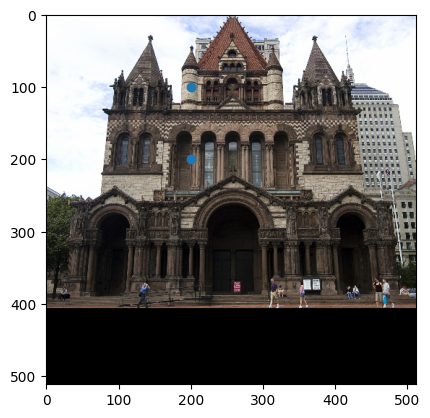

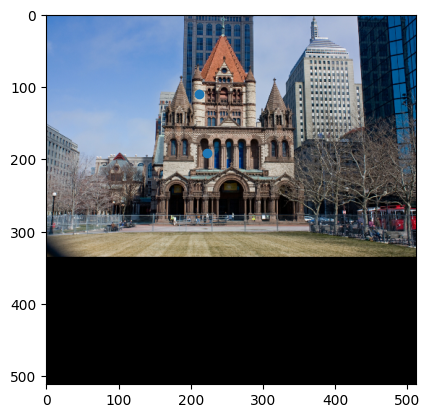

In [44]:
print(len(train_dataloader))

for i, batch in enumerate(train_dataloader):
    bitmaps, images = batch.to(DEV, non_blocking=True)
    break

image1 = bitmaps[0][0].permute(1,2,0).cpu().numpy()
image2 = bitmaps[0][1].permute(1,2,0).cpu().numpy()
image3 = bitmaps[0][2].permute(1,2,0).cpu().numpy()

# f, axarr = plt.subplots(1, 3, figsize=(8, 16)) 
# axarr[0].imshow(image1)
# axarr[1].imshow(image2)
# axarr[2].imshow(image3)

locations = torch.tensor(np.array([[200, 200], [200, 100]])).to(DEV)
imagea = images[0][0]
imageb = images[0][1]

reprojections = imageb.project(imagea.unproject(locations.T))
print(reprojections)

plt.figure()
plt.imshow(image1)
plt.scatter(locations[0].cpu().numpy(), locations[1].cpu().numpy())
plt.show()


plt.figure()
plt.imshow(image2)
plt.scatter(reprojections[0].cpu().numpy(), reprojections[1].cpu().numpy())
plt.show()



